# Query Retrieval Pipeline

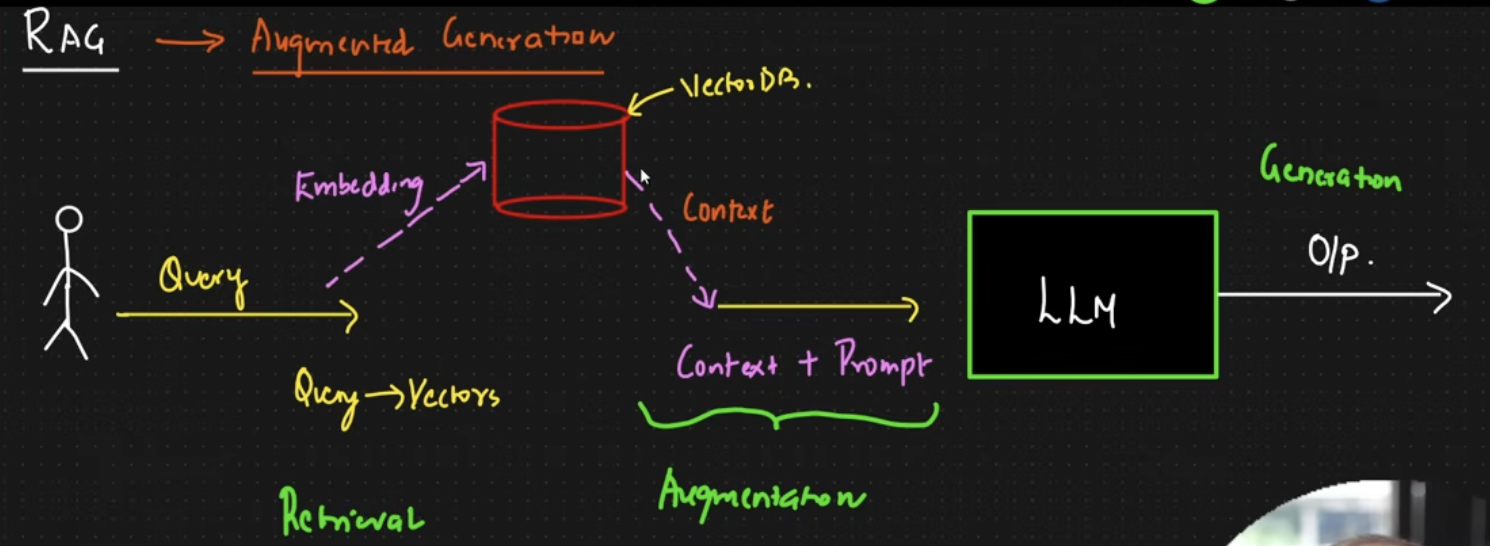

# Integration VectorDB Context Pipeline with LLM Output



In [2]:
# Simple RAG pileline with Groq LLM and LangChain
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
load_dotenv()

# Initialize Groq LLM
# groq_api_key = os.getenv("GROQ_API_KEY")
groq_api_key = "gsk_dzIp4litiRnJSrJC66zLWGdyb3Fh4v7"  # Replace with your actual Groq API key

llm = ChatGroq(groq_api_key=groq_api_key, model_name="gemma2-9b-it", temperature=0.1, max_tokens=1024)

## 2. Simple RAG Function: Retrieve context + generate response.
def rag_simple(query, retriever, llm, top_k=3):
    # Retrieve relevant documents / context
    results = retriever.retrieve(query, top_k=top_k)
    context = "\n\n".join([doc['content'] for doc in results]) if results else ""
    
    if not context:
        return "No relevant context found."

    # Generate response using LLM with context
    prompt = f"""Use the following context to answer the question concisely.
    Context: {context}
    Question: {query}
    Answer:"""

    response = llm.invoke(prompt.format(context=context, query=query))
    return response.content


In [ ]:
# import import_ipynb
# import 02_rag_data_ingestion_pipeline

%run 02_rag_data_ingestion_pipeline.ipynb




SyntaxError: invalid decimal literal (3247077016.py, line 2)

In [13]:
answer = rag_simple("What is Natural Language Processing?", rag_retriever, llm, top_k=3)
print("Answer:", answer)

Retrieving documents for query: What is Natural Language Processing?
Top K: 3, Score Threshold: 0.0
Generating Embedding for 1 texts...


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Generated embeddings with shape: (1, 384)
Retrieved 3 documents after applying score threshold.


AuthenticationError: Error code: 401 - {'error': {'message': 'Invalid API Key', 'type': 'invalid_request_error', 'code': 'invalid_api_key'}}

# Advanced RAG

In [14]:
def rag_advanced(query, retriever, llm, top_k=5, min_score=0.2, return_context=False):
    # RAG Pipeline with advanced options and extra features.
    results = retriver.retrieve(query, top_k=top_k, score_threshold=min_score)
    if not results:
        # return {'answer': "No relevant context found.", 'context': None} if return_context else "No relevant context found."
        return {'answer': "No relevant context found.", 'sources': [], 'confidence': 0.0, 'context': ''}

    # Prepare context and sources
    context = "\n\n".join([doc['content'] for doc in results])
    sources = [{
        'source': doc['metadata'].get('source_file', doc['metadata'].get('source', 'unknown')),
        'page': doc['metadata'].get('page', 'unknown'),
        'score': doc['similarity_score'],
        'preview': doc['content'][:200] + '...'  # First 200 characters as preview
    } for doc in results]
    confidence = max(doc['similarity_score'] for doc in results)

    # Generate Answer
    prompt = f"""Use the following context to answer the question concisely.
    Context: {context}
    Question: {query}
    Answer:"""
    response = llm.invoke([prompt.format(context=context, query=query)])

    output = {
        'answer': response.content,
        'sources': sources,
        'confidence': confidence,
    }
    if return_context:
        output['context'] = context
    return output

    


In [ ]:
# Test Advanced RAG
result = rag_advanced("Explain the concept of transformers in NLP.", rag_retriever, llm, top_k=5, min_score=0.1, return_context=True)
print("Answer:", result['answer'])
print("Confidence:", result['confidence'])
print("Sources:", result['sources'])
print("Context Preview:", result['context'][:500] + '...')  # Print first 500 characters of context